# Bank Marketing

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

## Attribute information
### Input variables
**Bank client data**
1. age :  (numeric)
2. job : type of job (categorical)
3. marital : marital status (categorical)
4. education (categorical)
5. default: has credit in default? (categorical)
6. balance: average yearly balance, in euros (numeric)
7. housing: has housing loan? (categorical)
8. loan: has personal loan? (categorical)

**Related with the last contact of the current campaign**  

9. contact: contact communication type (categorical)
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical)
12. duration: last contact duration, in seconds (numeric).

**Other attributes** 

13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical)

**Output variable (desired target)**

17. y - has the client subscribed a term deposit? (binary: 'yes','no')

# Goal: 

The classification goal is to predict if the client will subscribe a term deposit (variable y).

# Importing Necessory Libraries:

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from scipy import stats
import time

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [88]:
df = pd.read_csv('5. Data\Bank.csv', sep=';')

In [90]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no


## Exploratory Data Analysis:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


There are no null values and Dtype of all columns are in the right format.

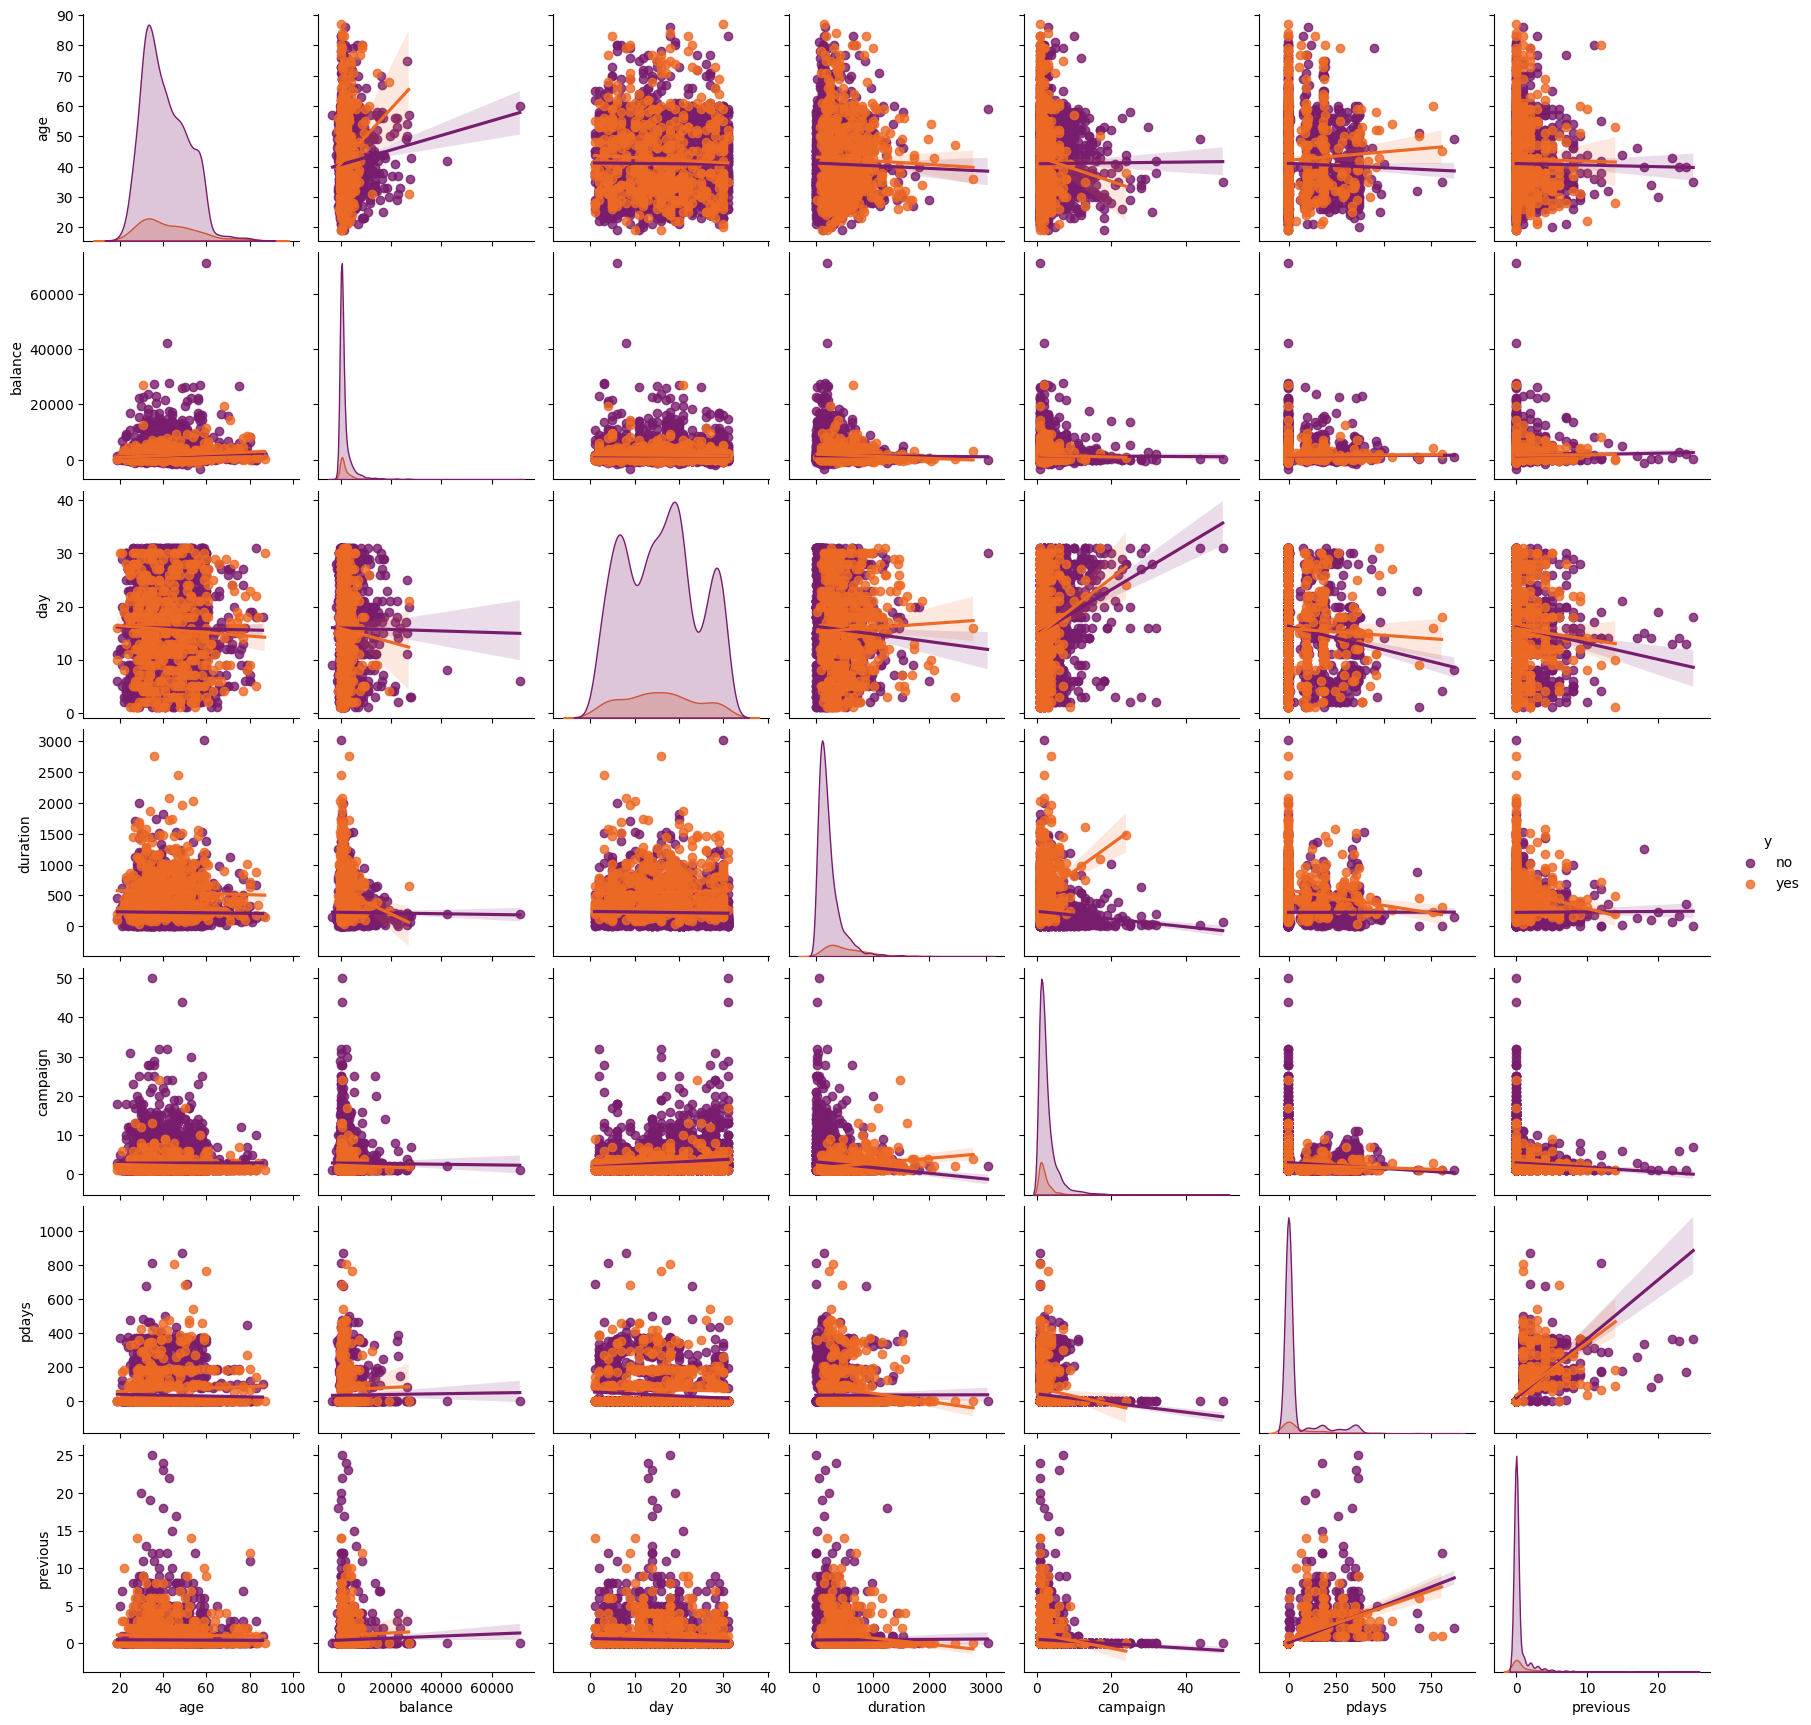

In [92]:
palette = 'inferno'
sns.pairplot(df, hue='y', kind='reg', palette=palette)
plt.show()

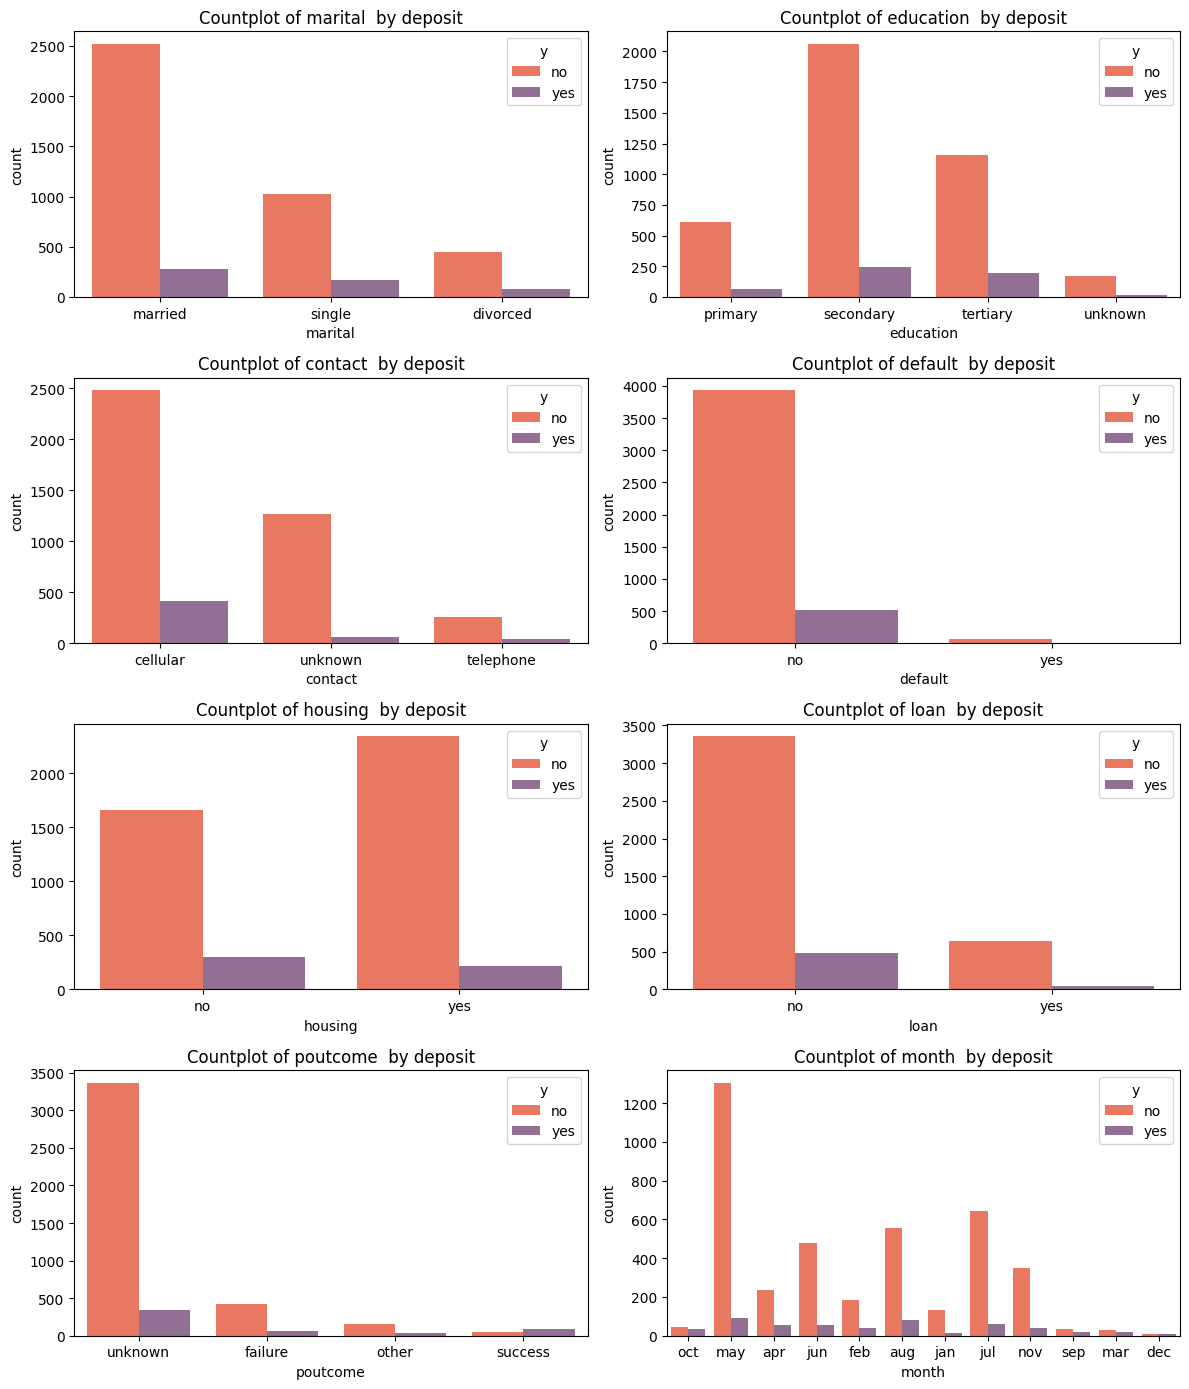

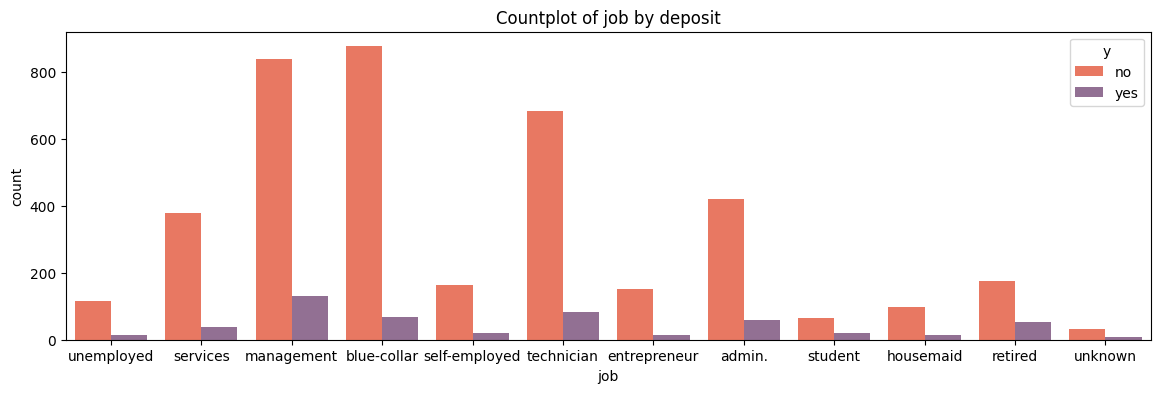

In [13]:
#barplots showing the frequency of each category separated by label
plt.figure(figsize=[12,14])

palette = ['#ff2a00', '#6c2b6d']
features=["marital", "education", "contact", "default", "housing", "loan", "poutcome", "month"]
n=1
for f in features:
    plt.subplot(4,2,n)
    sns.countplot(x=f, hue='y', palette=palette, alpha=0.7, data=df)
    plt.title("Countplot of {}  by deposit".format(f))
    n=n+1
plt.tight_layout()
plt.show()


    
plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='y',palette=palette, alpha=0.7, data=df)
plt.title("Countplot of job by deposit")
plt.show()

In [14]:
list(sns.color_palette('flare').as_hex())

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']

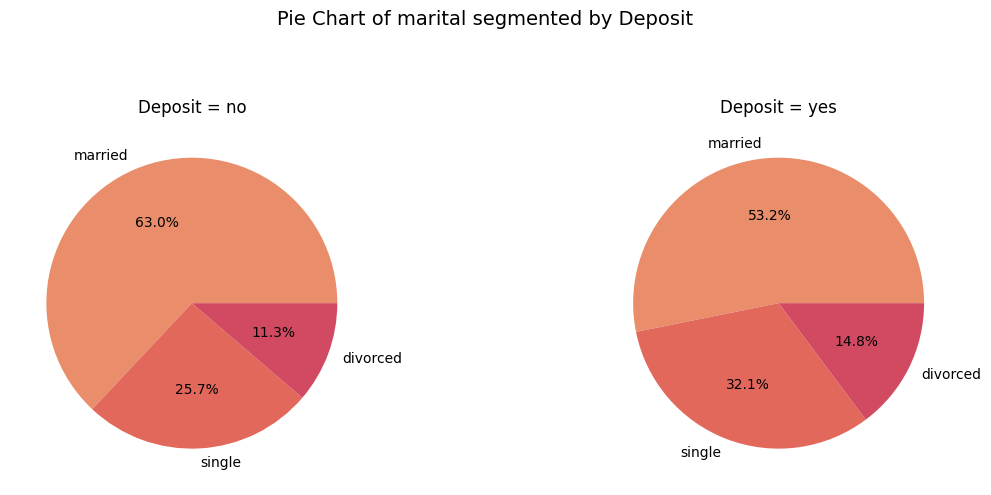

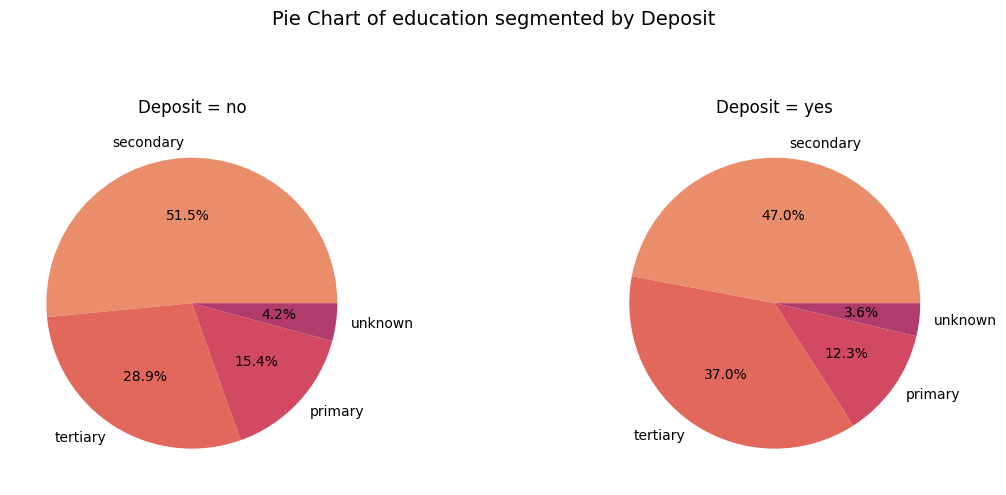

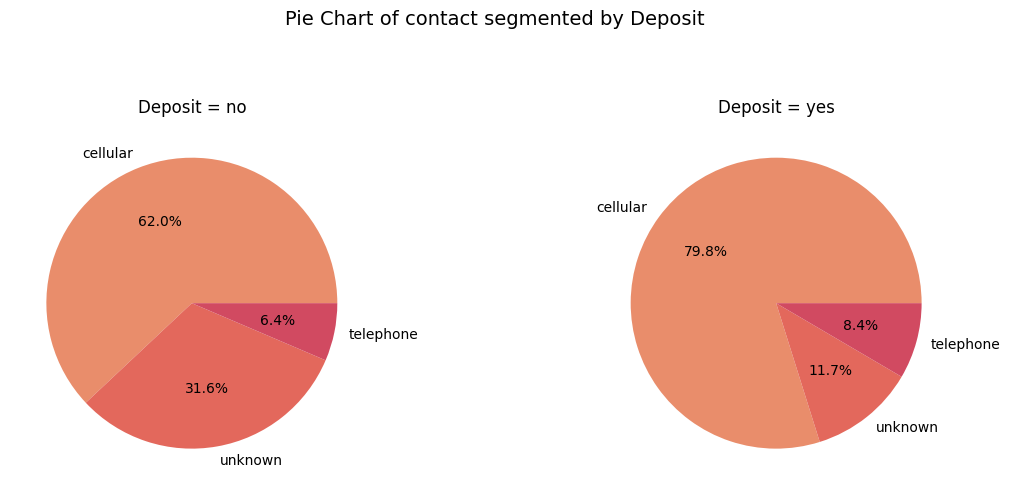

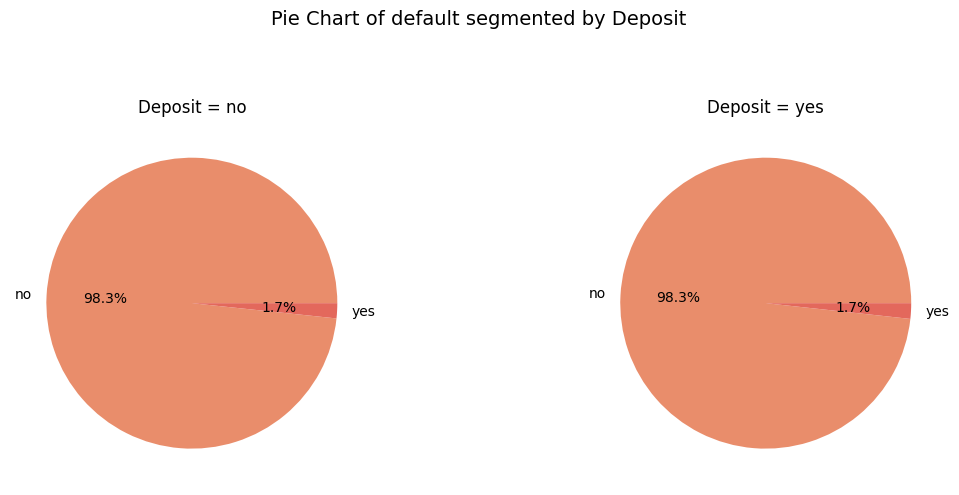

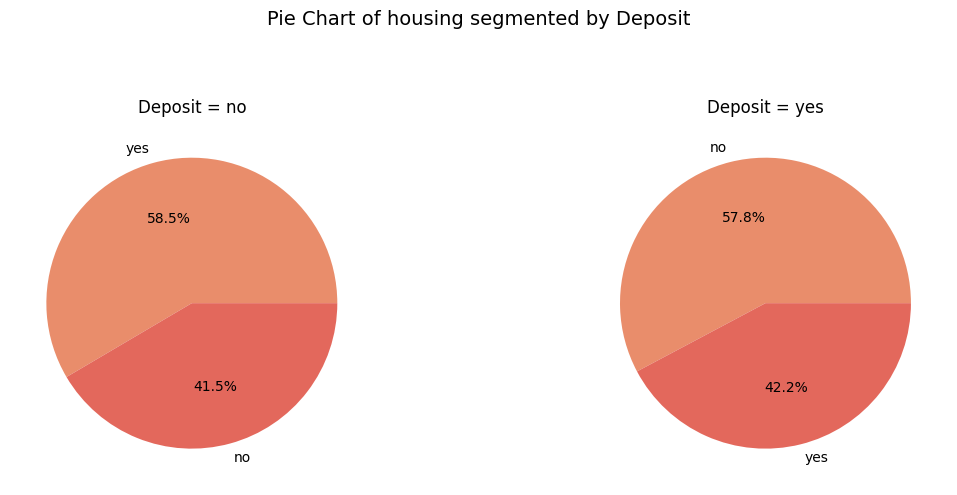

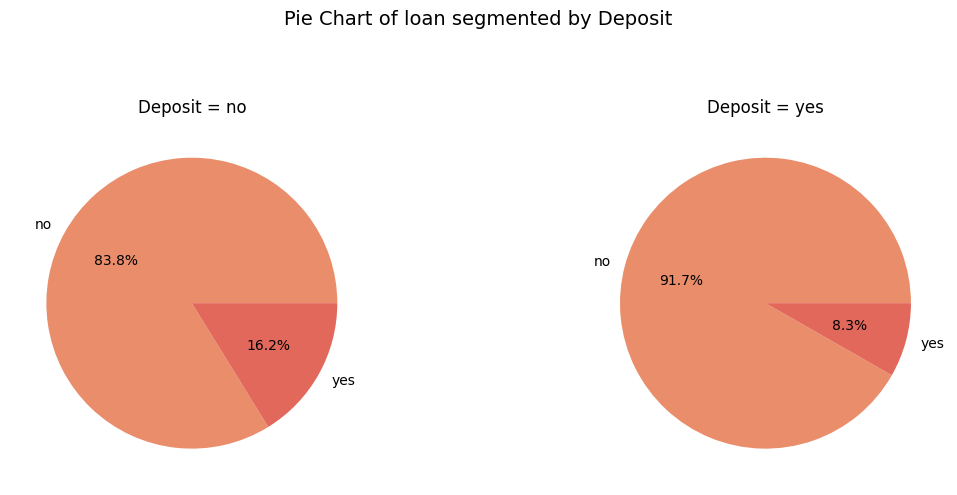

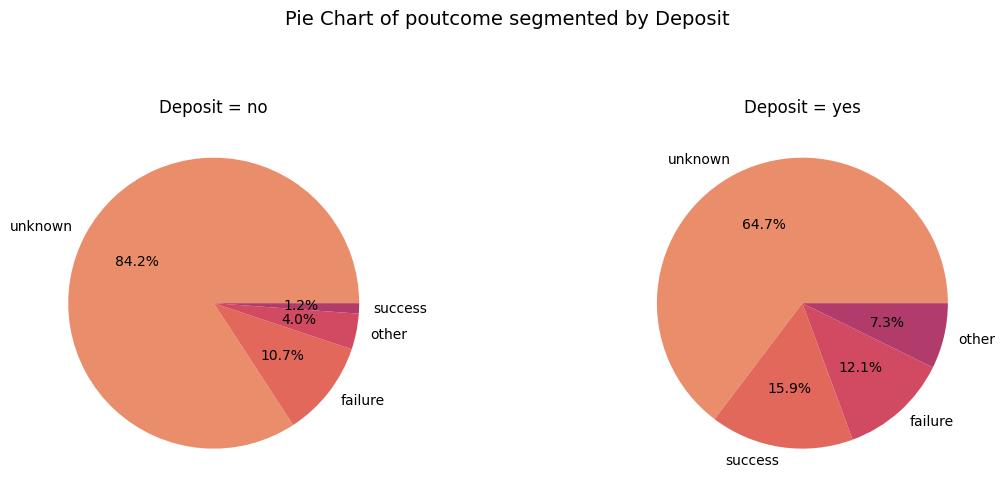

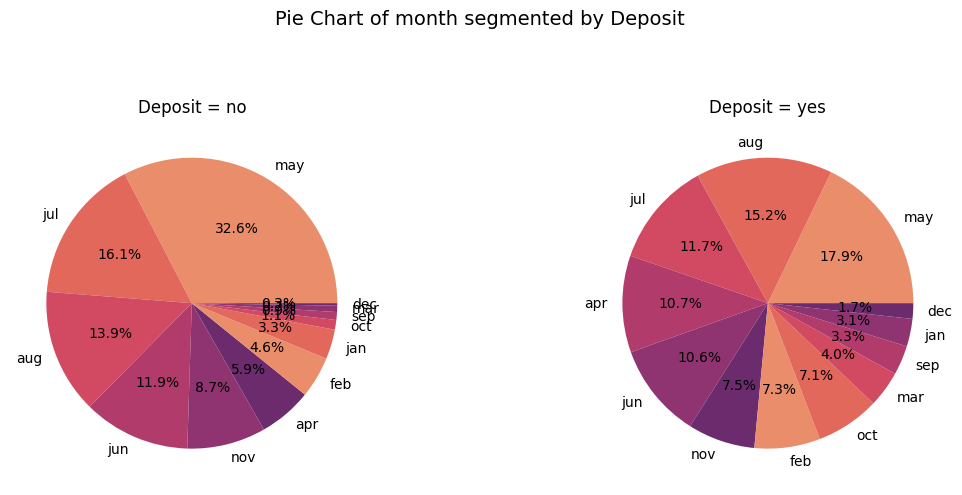

In [15]:
import matplotlib.pyplot as plt

palette = list(sns.color_palette('flare').as_hex()) 
features = ["marital", "education", "contact", "default", "housing", "loan", "poutcome", "month"]

for f in features:
    labels = df[f].unique()
    y_classes = df['y'].unique()
    
    fig, axs = plt.subplots(1, len(y_classes), figsize=(12, 5))
    fig.suptitle(f'Pie Chart of {f} segmented by Deposit', fontsize=14)
    
    for i, y_val in enumerate(y_classes):
        values = df[df['y'] == y_val][f].value_counts()
        axs[i].pie(values, labels=values.index, autopct='%1.1f%%', colors=palette)
        axs[i].set_title(f"Deposit = {y_val}")
    
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust space for suptitle
    plt.show()


**Takeaways:**   
- People who are **Single and divorced** tend to accept Term Deposit more.
- People having **Primary and Tertiary** Education tend to accept Term Deposite more.
- People having **cellular** contact tend to accept Term Deposite more.
- People having **no loan** tend to accept Term Deposite more.
- People whose poutcome is **success** tend to accept Term Deposite more.

In [17]:
df['y'].unique()

array(['no', 'yes'], dtype=object)

In [18]:
df_cat = [col for col in df.columns if df[col].dtype == 'object']

In [19]:
df[df_cat] = OrdinalEncoder().fit_transform(df[df_cat]) # Ecnoding Categorical Data

In [20]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10.0,1.0,0.0,0.0,1787,0.0,0.0,0.0,19,10.0,79,1,-1,0,3.0,0.0
1,33,7.0,1.0,1.0,0.0,4789,1.0,1.0,0.0,11,8.0,220,1,339,4,0.0,0.0


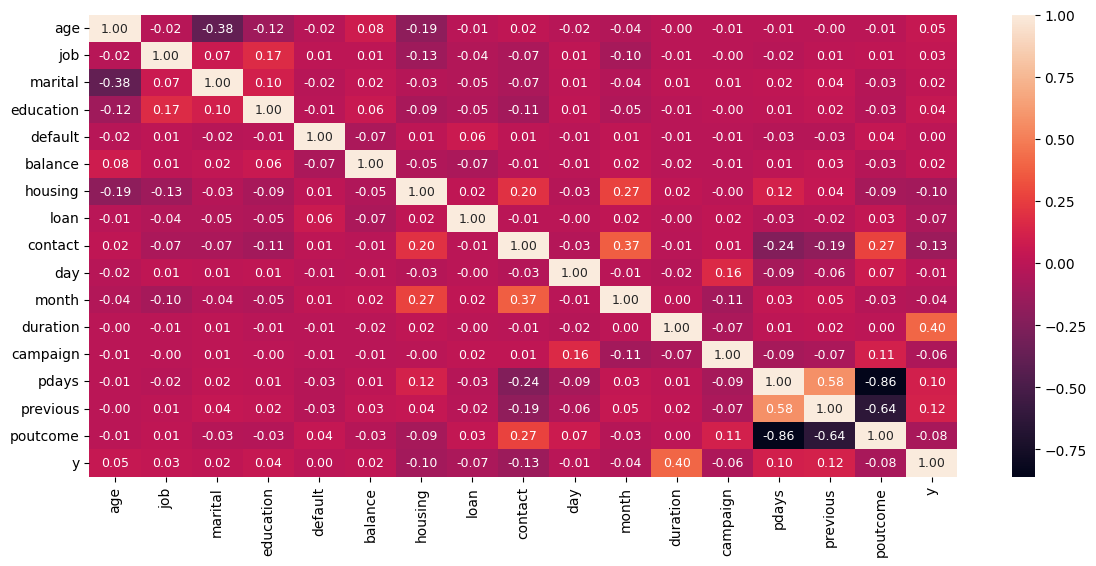

In [21]:
df_corr = df.corr()

plt.figure(figsize=(14, 6))

sns.heatmap(df_corr, annot=True, annot_kws={'size':9}, fmt='.2f')
plt.show()

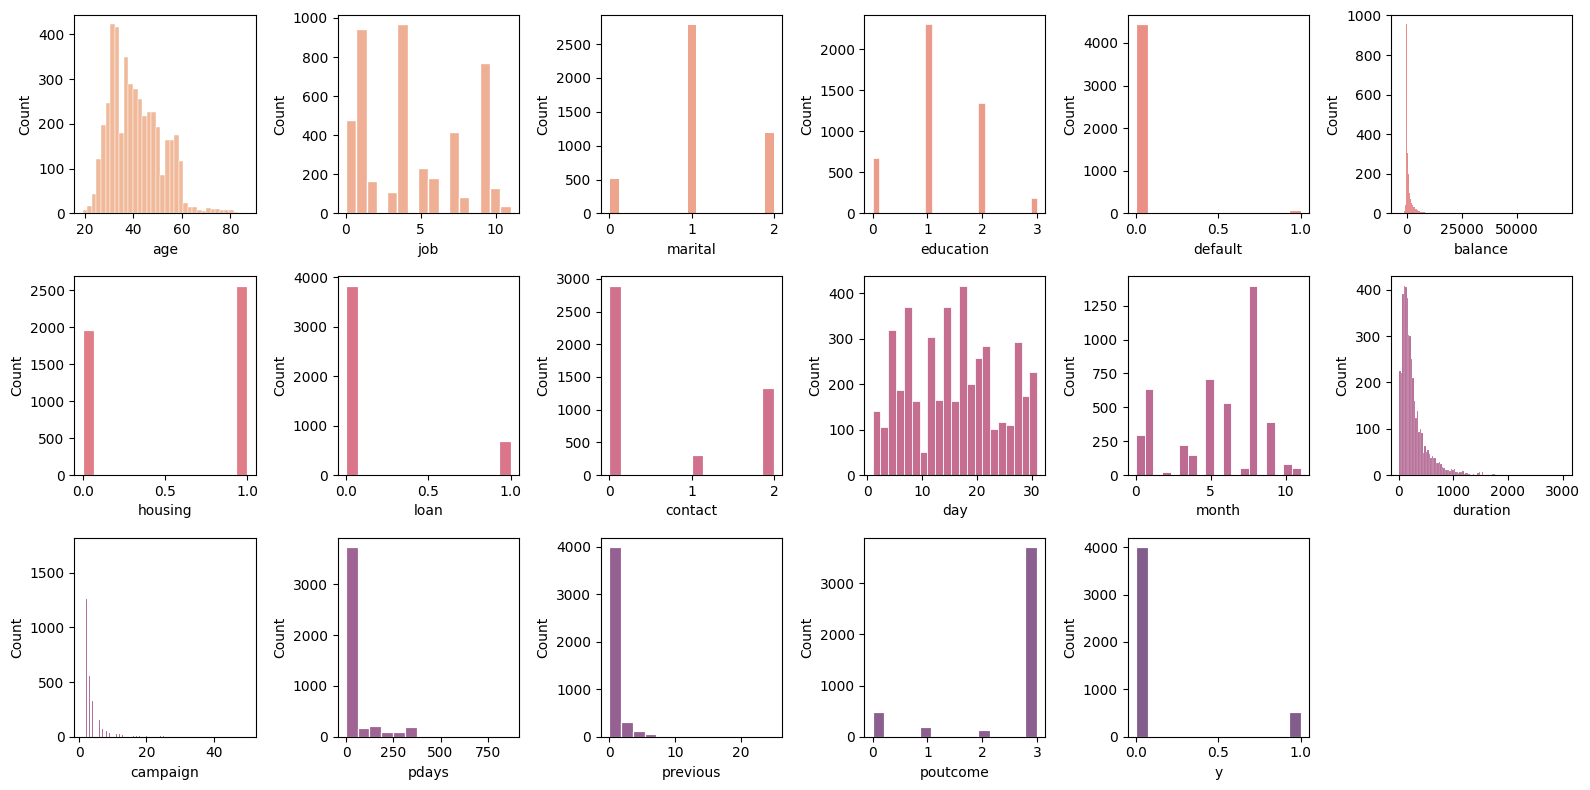

In [22]:
plt.figure(figsize=(16, 8))

palette = sns.color_palette("flare", n_colors=len(df.columns))

for idx, col in enumerate(df.columns):
    plt.subplot(3, 6, idx+1) 
    sns.histplot(df[col], color=palette[idx], edgecolor='white')
    plt.tight_layout()

plt.show()

## Machine Learning Modelling:

In [24]:
X = df.drop(columns=['y'])
y = df['y']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

### 1. Logistic Regression:

In [27]:
LR_model = LogisticRegression()

LR_model.fit(X_train, y_train)

y_pred_LR = LR_model.predict(X_test)

print('Linear Regression Report:\n\n', classification_report(y_test, y_pred_LR))

Linear Regression Report:

               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       801
         1.0       0.58      0.14      0.23       104

    accuracy                           0.89       905
   macro avg       0.74      0.57      0.59       905
weighted avg       0.86      0.89      0.86       905



The model is performing well on class 0 but poor with class 1 it is because of the class imbalance.

### 2. Decision Tree Classifier:

In [30]:
DTC_model = DecisionTreeClassifier()

DTC_model.fit(X_train, y_train)
y_pred_DTC = DTC_model.predict(X_test)

print('Decision Tree Classifier Report:\n\n', classification_report(y_test, y_pred_DTC))

Decision Tree Classifier Report:

               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       801
         1.0       0.40      0.44      0.42       104

    accuracy                           0.86       905
   macro avg       0.66      0.68      0.67       905
weighted avg       0.87      0.86      0.86       905



### 3. Random Forest Classifier:

In [32]:
RFC_model = RandomForestClassifier()

RFC_model.fit(X_train, y_train)
y_pred_RFC = RFC_model.predict(X_test)

print('Random Forest Classifier Report:\n\n', classification_report(y_test, y_pred_RFC))

Random Forest Classifier Report:

               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       801
         1.0       0.65      0.33      0.44       104

    accuracy                           0.90       905
   macro avg       0.79      0.65      0.69       905
weighted avg       0.89      0.90      0.89       905



### 4. Extra Trees Classifier:

In [34]:
ETC_model = ExtraTreesClassifier()

ETC_model.fit(X_train, y_train)
y_pred_ETC = ETC_model.predict(X_test)

print('Extra Trees Classifier Report:\n\n', classification_report(y_test, y_pred_ETC))

Extra Trees Classifier Report:

               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       801
         1.0       0.71      0.28      0.40       104

    accuracy                           0.90       905
   macro avg       0.81      0.63      0.67       905
weighted avg       0.89      0.90      0.88       905



### 5. XGBoost Classifier:

In [36]:
XGBC_model = XGBClassifier()

XGBC_model.fit(X_train, y_train)
y_pred_XGBC = XGBC_model.predict(X_test)

print('XGBoost Classifier Report:\n\n', classification_report(y_test, y_pred_XGBC))

XGBoost Classifier Report:

               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       801
         1.0       0.62      0.41      0.50       104

    accuracy                           0.90       905
   macro avg       0.78      0.69      0.72       905
weighted avg       0.89      0.90      0.90       905



### 6. Voting Classifier:

In [38]:
VC_model = VotingClassifier(estimators=[
    ('LR', LR_model),
    ('DTC', DTC_model),
    ('RFC', RFC_model),
    ('ETC', ETC_model),
    ('XGBC', XGBC_model)
], voting='soft')

VC_model.fit(X_train, y_train)
y_pred_VC = VC_model.predict(X_test)

print('Voting Classifier Report:\n\n', classification_report(y_test, y_pred_VC))


Voting Classifier Report:

               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       801
         1.0       0.64      0.35      0.45       104

    accuracy                           0.90       905
   macro avg       0.78      0.66      0.70       905
weighted avg       0.89      0.90      0.89       905



Using SMOTE

In [40]:
VC_model = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', VC_model)
])

VC_model.fit(X_train, y_train)

y_pred_VC = VC_model.predict(X_test)

print("Voting Classifier Report (SMOTE + Soft Voting):\n\n")
print(classification_report(y_test, y_pred_VC))

Voting Classifier Report (SMOTE + Soft Voting):


              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       801
         1.0       0.56      0.45      0.50       104

    accuracy                           0.90       905
   macro avg       0.75      0.70      0.72       905
weighted avg       0.89      0.90      0.89       905



In [41]:
from sklearn.metrics import precision_recall_curve

# Get probabilities for class 1
y_proba = VC_model.predict_proba(X_test)[:, 1]

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Best threshold
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1_scores[best_idx]:.2f}")

# Use it to predict
y_pred_best = (y_proba >= best_threshold).astype(int)

# Final report
from sklearn.metrics import classification_report
print("Voting Classifier Report (SMOTE + Soft Voting + Tuned Threshold):\n")
print(classification_report(y_test, y_pred_best))


Best Threshold: 0.45
Precision: 0.56, Recall: 0.56, F1: 0.56
Voting Classifier Report (SMOTE + Soft Voting + Tuned Threshold):

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       801
         1.0       0.56      0.56      0.56       104

    accuracy                           0.90       905
   macro avg       0.75      0.75      0.75       905
weighted avg       0.90      0.90      0.90       905



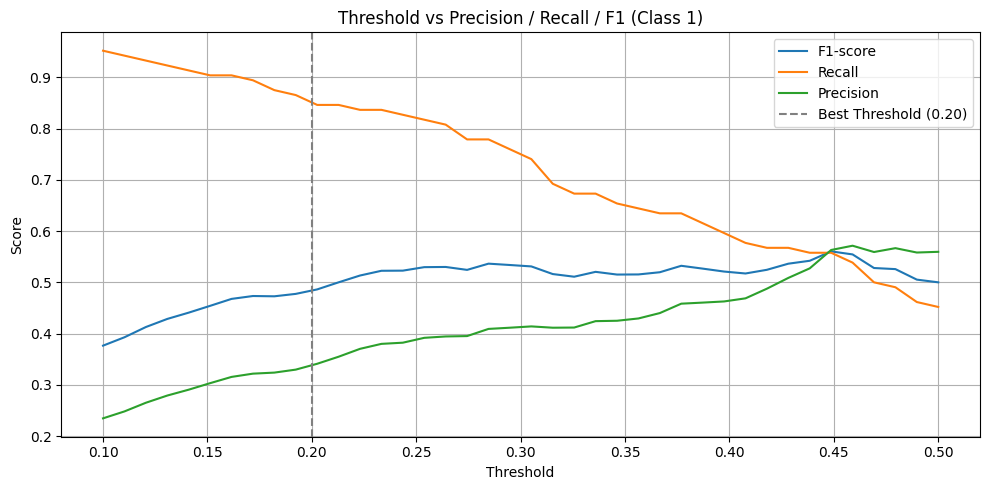

In [42]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.linspace(0.1, 0.5, 40)
f1_scores = []
recalls = []
precisions = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_scores.append(report['1.0']['f1-score'])
    recalls.append(report['1.0']['recall'])
    precisions.append(report['1.0']['precision'])

plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.axvline(x=0.2, color='gray', linestyle='--', label='Best Threshold (0.20)')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision / Recall / F1 (Class 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Confusion Matrix


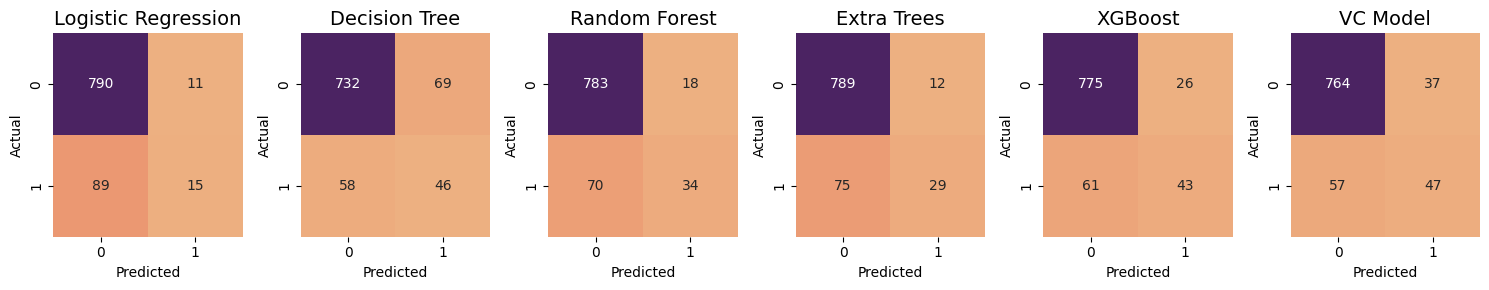

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

models = {
    'Logistic Regression': y_pred_LR,
    'Decision Tree': y_pred_DTC,
    'Random Forest': y_pred_RFC,
    'Extra Trees': y_pred_ETC,
    'XGBoost': y_pred_XGBC,
    'VC Model': y_pred_VC
}

print('Confusion Matrix')
plt.figure(figsize=(15, 3))
for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 6, i)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', cbar=False)
    plt.title(f'{name}', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()


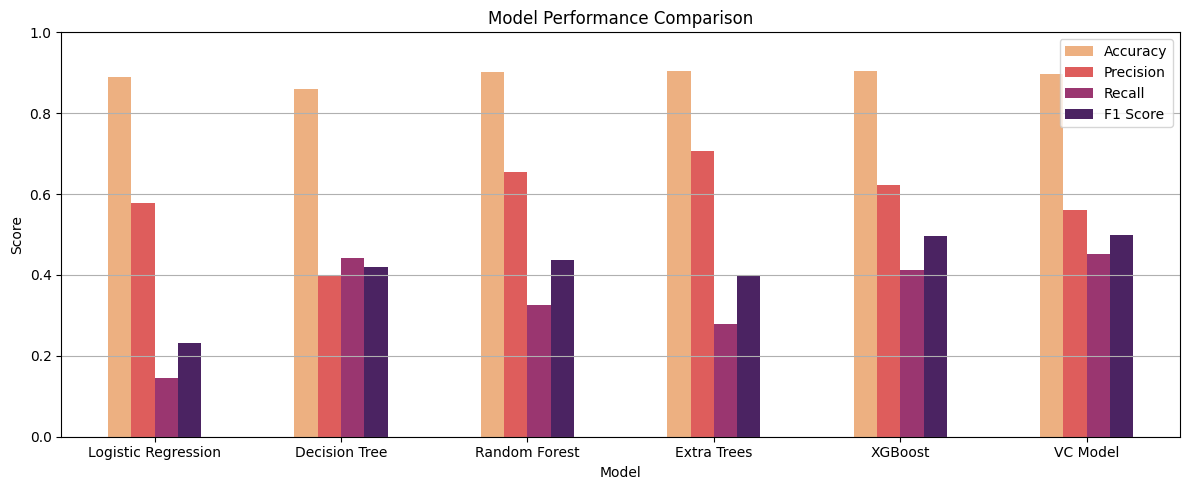

In [44]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

scores = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

for name, preds in models.items():
    scores["Model"].append(name)
    scores["Accuracy"].append(accuracy_score(y_test, preds))
    scores["Precision"].append(precision_score(y_test, preds))
    scores["Recall"].append(recall_score(y_test, preds))
    scores["F1 Score"].append(f1_score(y_test, preds))

score_df = pd.DataFrame(scores)

score_df.set_index("Model").plot(kind="bar", figsize=(12, 5), colormap='flare')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


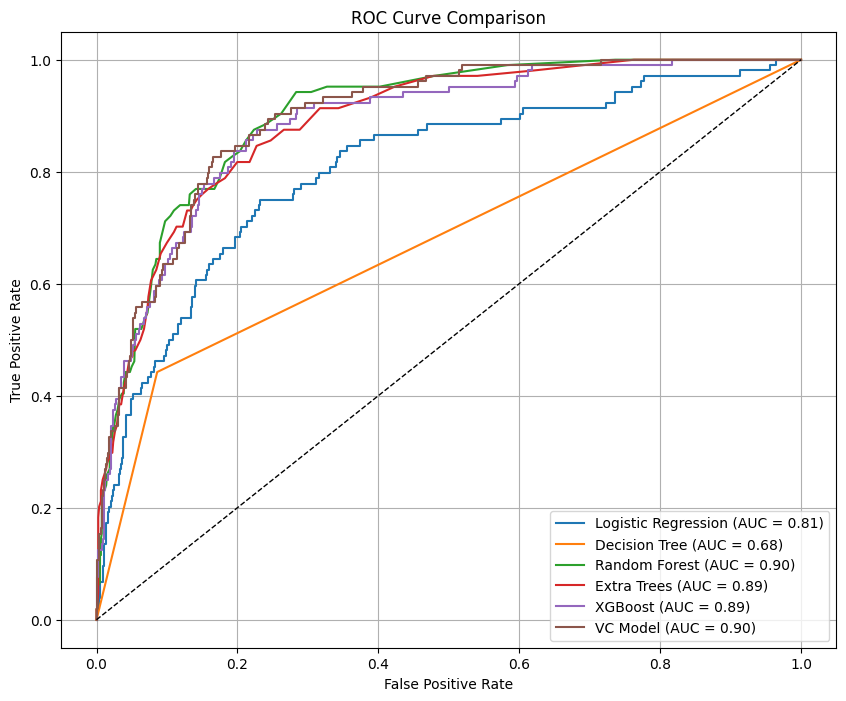

In [45]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for name, model in [
    ('Logistic Regression', LR_model),
    ('Decision Tree', DTC_model),
    ('Random Forest', RFC_model),
    ('Extra Trees', ETC_model),
    ('XGBoost', XGBC_model),
    ('VC Model', VC_model)
]:
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

According to ROC curve the **best Model** is **Random Forest**